# Assembling thermal circuits

Objectives:
* Assemble complex circuits.
* Simulate the assembled circuits.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import tuto

Maximum time step in free-floating: 479.08 s


## Defining the problem of circuit assembling

The problem of assembling thermal circuits can be stated as:

Given a number of thermal circuits, $TC_1$, $TC_2$, ... , $TC_n$, and knowing that some of their nodes are common, find the assembled circuit TC (see figure below).

![circuit](t04_circuit.png)
> Example of the problem of assembling thermal circuits: given four circuits, assemble them knowing the common nodes. The heat-flow sources and the capacities in the nodes are divided for each circuit

From conservation of energy, it results that if there is a flow source in the node, it needs to be the sum of the sources of each circuit; a simple solution is to be divided equally by each circuit. From conservation of mass, it results that if there is a common capacity in the node, it needs to be the sum of the sources of each circuit; a simple solution is to be divided equally by each circuit.

To exemplify the procedure, we will use the same model from tutorial `t03CubeFB` representing a room with insulated concrete wall and a glass wall. The room is ventilated and the temperature is controlled by a P-controller to which additional load is added. The toy model is used to show specific aspects of the assembling procedure, not for correctness of the modelling.

![assembling](t04_assembling.png)
> Elementary models that will be assembled

![matrices](t04_matrices.png)
> Algebraic representation of the termal circuit: a) Assemblu-connectivity matrix; b) elementary thermal circuits.

We would like to construct separate models for concrete wall, glass wall, ventilation, and room air and to assemble them into one model (see figure above).

## Numbering the circuits

### Numbering elementary circuits

In principle, the numbering of the nodes and branches can be done arbitrarily. The connections are indicated by the oriented incidence matrix **A**. Since numbering becomes tedious for large circuits, the following rules may be adopted:
- number the nodes in order (e.g. from left to right);
- number the branches in increasing order of nodes and orient them from the lower to the higher node. Note: reference temperature is node 0.

### Numbering the assembled circuit
When assembling the thermal circuits, some nodes are put in common. Therefore, the number of nodes in the assembled circuit will be smaller than the sum of the nodes of elementary circuits. The number of branches will not change. The nodes and the branches of the assembled circuit will be in the order of assembling.

|Local and global indexing of nodes|
|----------------------------------|

|Thermal circuit  |TC1       |TC2     |TC3  |TC4|
|-----------------|----------|--------|-----|-|
|Local node index |1 2 3 4 5 |1  2  3 |1  2 |1|
|Global node index|1 2 3 4 5 |5  6  7 |8  6 |7|

|Local and global indexing of branches|
|-------------------------------------|

|Thermal circuit    |TC1       |TC2   |TC3  |TC4 |
|-------------------|----------|--------|-----|-|
|Local branch index |1 2 3 4 5 |1 2 3 |1 2  | 1 2|
|Global branch index|1 2 3 4 5 |6 7 8 |9 10 |11 12|

The assembling of the circuits is indicated by the assembling matrix. Each row of this matrix has four elements that indicate two nodes that will be put together:
- number of circuit 1
- node of circuit 1
- number of circuit 2 
- node of circuit 2

For our example, the assembling matrix is:

$$\mathbf{A_{ss}} =\begin{bmatrix}
0 & 4 & 1 & 0\\ 
1 & 1 & 2 & 1\\ 
1 & 2 & 3 & 0
\end{bmatrix}$$

The description of the disassembled circuits, given by the dictionary $TC_d = \{TC_0,…,TC_n\}$ of dictionaries $TC_i=\{A_i,G_i,b_i,C_i,f_i,y_i\}$, and the assembling matrix $A_{ss}$ contain all the necessary information for obtaining the assembled circuit. 

## Procedure for assembling
The assembling is implemented in function `thermal_circuit(Kp)`.

$K_p$ is the gain of the P-controller:
* If $K_p \rightarrow \infty$, then the controller tends towards perfection, i.e., the indoor temperature tends towards its set-point.
* If $K_p \rightarrow  0$, then the controller is uneffective, i.e., the indoor temperature is in free-floating.

The thermal conductances and capacities are:

The elemntary thermal circuits are described by the matrices and vectors $A, G, b, C, f, y$.

The thermal circuit $TC_0$ (in red in figure) is formed convection on outside of the wall and conduction in meshes of concrete and insulation. The numbers of flow branches `nq` and of temperature nodes `nt`are:

The incidence matrix $A$ is a difference operator for temperatures:

The conductance matrix $G$ contains `nc` concrete meshes and `ni` insulation meshes. The conductances of the outdoor convection, conduction in cocrete and conduction in insulation are stacked horizontally. Then, $G$ is obtained as a diagonal matrix.

There is only one branch with a temperature source: branch `b[0]`.

The capacity matrix is:

There are two nodes with heat flow sources, the first and the last node: `f[0]`, `f[-1]`.

There is not temperature from circuit $TC_{d0}$ in the output vector:

The circuit $TC_{d0}$ is a dictionary having the matrices and vectors $A, G, b, C, f, y$:

The thermal circuits $TC_{d1}, TC_{d2}$ and $TC_{d3}$ are constructed similarly:

The *elementary* dissembled circuits, $TC_{d1}, ... TC_{d3}$ are put together in a dictionary. Note that the *elementary* circits may be used more than once in the dictionary.

The assembly matrix `AssX` indicates how the circuits are connected. For example, the 1st row of matrix `AssX` idicates that the last node (`nt - 1`) of circuit $TC_{d0}$ is merged with the 1st node of circuit $TC_{d1}$; the 1st node (i.e., node no. 0) of circuit $TC_{d1}$ is deleted.

Finall, the dissambles thermal circuit `TCd`is assabled according to the conexions indicated by the assembly matrix `AssX` by using the functionn `dm4bem.TCAss`. The result is an assambled thermal circuit with matrices and vectors $A, G, b, C, f, y$.

## Simulation

### Free-floating

Let's consider that the P-controller is not effective, i.e. $K_p \rightarrow 0$.

In [2]:
Kp = 1e-3   # no controller Kp -> 0

The assambled thermal circuit `TCa`is obtained as shown above:

In [3]:
TCa = tuto.thermal_circuit(Kp)

The thermal circuit `TCa` is converted to state-space representation: 

In [4]:
# Thermal circuit -> state-space
[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])

In [5]:
# Maximum time-step
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 479.08 s


We will chose a time step for integration slighly smaller than the maximum time step:

In [6]:
dt = 400  # [s] simulation time step

#### Step response

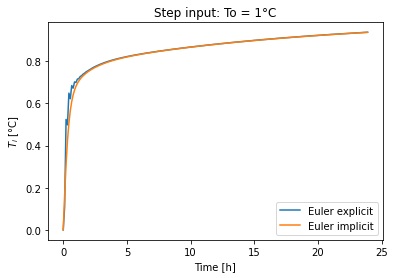

In [7]:
duration = 3600 * 24 * 1        # [s]
tuto.step_response(duration, dt, As, Bs, Cs, Ds)

#### Simulation with weather data

In [ ]:
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-03-04 18:00:00'
tuto.P_control(filename, start_date, end_date, dt,
               As, Bs, Cs, Ds, Kp)

### Perfect controller

Let's consider that controller is perfect, i.e. $K_p \rightarrow \infty$.

In [ ]:
Kp = 1e3    # P-controler gain, Kp -> ∞

The maximum timestep in this case is:

In [ ]:
TCa = tuto.thermal_circuit(Kp)
[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

#### Simulation with weather data

In [ ]:
dt = 50
tuto.P_control(filename, start_date, end_date, dt,
               As, Bs, Cs, Ds, Kp)